<a href="https://colab.research.google.com/github/khushidubeyokok/PyTorch/blob/main/05/Going_modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going modular: Turn useful notebook code cells into reusable python files

# Code mode :
#This contains a model trained on custom Foo101 dataset as in [notebook 04](https://github.com/khushidubeyokok/PyTorch/blob/main/04/custom_dataset.ipynb)

## Custom datasets - get your own dataasets into pytorch

In [1]:
import torch
from torch import nn
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get data - our dataset is a subset of Food101 dataset
Food101 datset starts with 101 classes and over 1000images per class (750 training and 250 testing)
our dataset starts with onyl 3 classes of food and only 10% of the images (~75 training and ~25 testing)

In [2]:
import requests
import zipfile
from pathlib import Path
import os


# setup path to a data folder
data_path=Path('data/')
image_path=data_path/"pizza_steak_sushi"

#if the image folder doesnt exist download it and prepare it
if image_path.is_dir():
  print(f"{image_path}exists,skipping download")
else:
  print(f"{image_path}does not exist, creating...")
  image_path.mkdir(parents=True,exist_ok=True)


#download data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

#unzipping zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)
print('done')

#remove the zip file
os.remove(data_path/'pizza_steak_sushi.zip')

data/pizza_steak_sushiexists,skipping download
done


## Data preparation and data exploration - Becoming one with the data

In [3]:
import os
def explore_dir(path):
  for dirpath,dirname,filename in os.walk(path):
    print(f"there are {len(dirname)} directories and {len(filename)} images in {dirpath}")

In [4]:
explore_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [5]:
# setup train and test dir
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualising image

1. get all image paths
2. open random image using random.choice()
3. get image labels using pathlib.Path.parent.stem()
4. open the image using python's PIL
5. show the image and print metadata

Images [PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg')]
random_image_path : data/pizza_steak_sushi/test/sushi/175783.jpg
image class : sushi
image height : 382
image width: 512


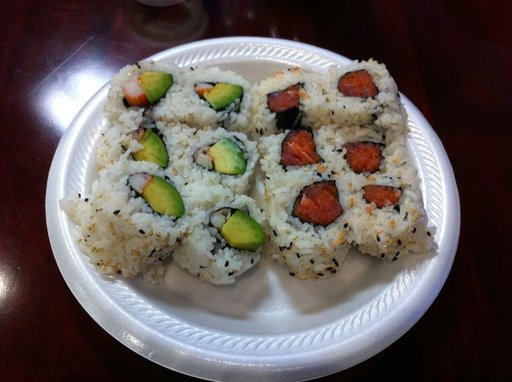

In [6]:
import random
from PIL import Image
random.seed(42)

# Get all image paths
image_path_list=list(image_path.glob('*/*/*.jpg'))
print(f"Images {image_path_list[:3]}")

# pick a random image
random_image_path=random.choice(image_path_list)

#get image class - image class is the name of the directory where the image is stored
image_class = random_image_path.parent.stem

#open the image
img = Image.open(random_image_path)

#print metadata
print(f"random_image_path : {random_image_path}")
print(f"image class : {image_class}")
print(f"image height : {img.height}")
print(f"image width: {img.width}")
img

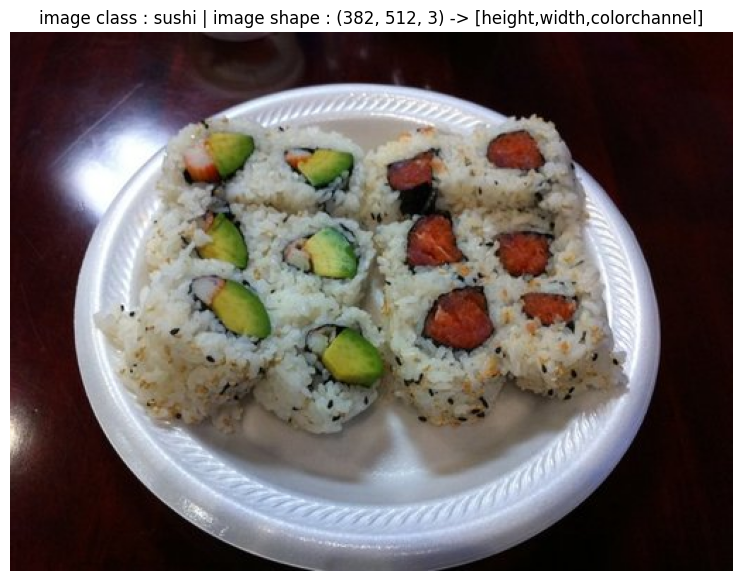

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"image class : {image_class} | image shape : {img_as_array.shape} -> [height,width,colorchannel]")
plt.axis(False);

## Create dataset and dataloaders

1. turn data into tensors
2. turn tensors into `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`, we will call these are 'dataset' and 'dataloader'

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms


# transform images

data_transform=transforms.Compose([
    # resize image
    transforms.Resize(size=(64,64)),
    #flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    #turn into tensor
    transforms.ToTensor()
    ])

# use ImageFolder to create dataset(s)
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform,target_transform=None)


# get class names as list
class_names=train_data.classes
print(f"class names list: {class_names}, class names as dictionary: {train_data.class_to_idx}")

train_dataloader=DataLoader(dataset=train_data,batch_size=1,num_workers=os.cpu_count(),shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=1,num_workers=os.cpu_count(),shuffle=True)
print(f"{len(train_dataloader)},{len(test_dataloader)}")


img,label=next(iter(train_dataloader))
print(f"image tensor : {img[:1]}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label : {label}")
print(f"label datatype: {label.shape}")

class names list: ['pizza', 'steak', 'sushi'], class names as dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}
225,75
image tensor : tensor([[[[0.0157, 0.0235, 0.0275,  ..., 0.9686, 0.9333, 0.9059],
          [0.0275, 0.0314, 0.0353,  ..., 0.9765, 0.9373, 0.9059],
          [0.0353, 0.0392, 0.0431,  ..., 0.9922, 0.9765, 0.9529],
          ...,
          [0.7255, 0.7333, 0.7373,  ..., 0.2902, 0.2980, 0.2980],
          [0.7020, 0.7216, 0.7294,  ..., 0.2627, 0.2824, 0.2706],
          [0.6431, 0.6784, 0.7059,  ..., 0.2784, 0.2784, 0.2667]],

         [[0.0510, 0.0510, 0.0510,  ..., 0.9961, 0.9961, 0.9882],
          [0.0471, 0.0471, 0.0471,  ..., 0.9961, 0.9922, 0.9843],
          [0.0471, 0.0510, 0.0588,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.8353, 0.8431, 0.8510,  ..., 0.3373, 0.3294, 0.3373],
          [0.8157, 0.8314, 0.8353,  ..., 0.3020, 0.3137, 0.3098],
          [0.7490, 0.7922, 0.8196,  ..., 0.3059, 0.3176, 0.3020]],

         [[0.0196, 0.0235, 0.0235,  ..., 

## Model_0: Tiny VGG

In [9]:
simple_transform=transforms.Compose([transforms.Resize(size=(64,64)),transforms.ToTensor()])

In [10]:
# load images as dataset
from torchvision.datasets import ImageFolder
train_data_simple=ImageFolder(root=train_dir,transform=simple_transform,target_transform=None)
test_data_simple=ImageFolder(root=test_dir,transform=simple_transform,target_transform=None)

In [11]:
# turn dataset into dataloader
from torch.utils.data import DataLoader
import os
train_dataloader_simple=DataLoader(dataset=train_data_simple,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_dataloader_simple=DataLoader(dataset=test_data_simple,batch_size=32,shuffle=False,num_workers=os.cpu_count())

In [12]:
class TinyVGG(nn.Module):
  def __init__(self,input,hidden_units,output):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block3=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(nn.Flatten(),
                                  nn.Linear(in_features=hidden_units*4*4,out_features=output))

  def forward(self,x):
    x=self.block1(x)
    #print(x.shape)
    x=self.block2(x)
    #print(x.shape)
    x=self.block3(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x

In [13]:
model_0=TinyVGG(input=3,hidden_units=60,output=len(class_names)).to(device) #input is number of color channels in our data
model_0

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=960, out_features=3, bias=True)
  )
)

## Try a forward pass on a single image


In [14]:
# get a simple image batch
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

# try a forward pass
model_0(image_batch.to(device))



tensor([[ 0.0087, -0.0123,  0.0018],
        [ 0.0085, -0.0119,  0.0018],
        [ 0.0078, -0.0121,  0.0019],
        [ 0.0080, -0.0125,  0.0022],
        [ 0.0091, -0.0121,  0.0017],
        [ 0.0089, -0.0116,  0.0019],
        [ 0.0094, -0.0118,  0.0023],
        [ 0.0092, -0.0110,  0.0017],
        [ 0.0094, -0.0117,  0.0013],
        [ 0.0089, -0.0121,  0.0020],
        [ 0.0077, -0.0123,  0.0020],
        [ 0.0081, -0.0130,  0.0026],
        [ 0.0087, -0.0124,  0.0022],
        [ 0.0085, -0.0121,  0.0025],
        [ 0.0082, -0.0123,  0.0023],
        [ 0.0085, -0.0124,  0.0027],
        [ 0.0083, -0.0120,  0.0019],
        [ 0.0087, -0.0115,  0.0021],
        [ 0.0087, -0.0120,  0.0016],
        [ 0.0090, -0.0114,  0.0019],
        [ 0.0092, -0.0123,  0.0024],
        [ 0.0079, -0.0117,  0.0021],
        [ 0.0085, -0.0117,  0.0019],
        [ 0.0097, -0.0118,  0.0017],
        [ 0.0094, -0.0119,  0.0019],
        [ 0.0090, -0.0122,  0.0018],
        [ 0.0087, -0.0122,  0.0022],
 

In [15]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 60, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 60, 62, 62]           1,680
│    └─ReLU: 2-2                         [1, 60, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 60, 60, 60]           32,460
│    └─ReLU: 2-4                         [1, 60, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 60, 30, 30]           --
├─Sequential: 1-2                        [1, 60, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 60, 28, 28]           32,460
│    └─ReLU: 2-7                         [1, 60, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 60, 26, 26]           32,460
│    └─ReLU: 2-9                         [1, 60, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 60, 13, 13]           --


## Create training and testing functions

In [16]:
def train_model(model,dataloader,loss_function,optimiser):
  model=model.to(device)
  model.train()
  train_loss=0
  train_acc=0
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)
    y_pred=model(X) #output model logits
    loss=loss_function(y_pred,y)
    train_loss+=loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    #calculate accuracy
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)

  return train_loss,train_acc

In [17]:
def test_model(model,dataloader,loss_function,optimiser):
  model=model.to(device)
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)
      test_pred_logits=model(X)
      loss=loss_function(test_pred_logits,y)
      test_loss+=loss.item()
      test_pred_class=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_class==y).sum().item()/len(test_pred_class)

    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)

  return test_loss,test_acc

In [18]:
def train_and_test_model(model,epochs,train_dataloader,test_dataloader,loss_function,optimiser):
  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  start = timer()
  results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_model(model,train_dataloader,loss_function,optimiser)
    test_loss,test_acc=test_model(model,test_dataloader,loss_function,optimiser)
    print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc*100:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  end = timer()
  time_taken=end-start
  print(f"time_taken:{time_taken}")
  return results

## Training and evaluating model_0

In [19]:
lossfn=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(params=model_0.parameters(),lr=0.1)

In [20]:
torch.manual_seed(42)
model_0=TinyVGG(input=3,hidden_units=20,output=len(class_names)).to(device)

In [21]:
model_0_results=train_and_test_model(model=model_0,epochs=5,train_dataloader=train_dataloader_simple,test_dataloader=test_dataloader_simple,loss_function=lossfn,optimiser=optimiser)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1032 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 2 | train_loss: 1.1032 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 3 | train_loss: 1.1033 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 4 | train_loss: 1.1032 | train_acc: 30.4688% | test_loss: 1.1101 | test_acc: 26.0417%
Epoch: 5 | train_loss: 1.0921 | train_acc: 42.5781% | test_loss: 1.1101 | test_acc: 26.0417%
time_taken:11.57263520999993


In [22]:
from typing import Dict,List,Tuple
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

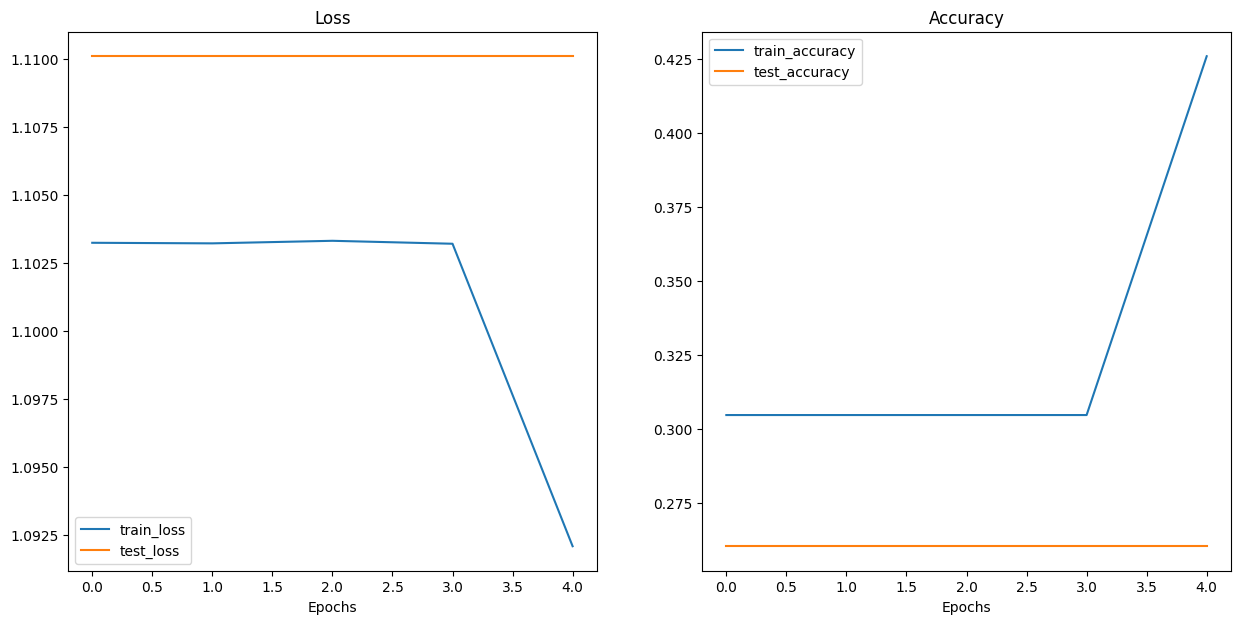

In [23]:
plot_loss_curves(model_0_results)

## Save the model

In [24]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [25]:
save_model(model=model_0,
           target_dir="models",
           model_name="05_going_modular_cell_mode_tinyvgg_model.pth")

[INFO] Saving model to: models/05_going_modular_cell_mode_tinyvgg_model.pth


# Script mode :

In [26]:
import torch
from torch import nn
from torchvision import transforms
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
import requests
import zipfile
from pathlib import Path
import os


# setup path to a data folder
data_path=Path('data/')
image_path=data_path/"pizza_steak_sushi"

#if the image folder doesnt exist download it and prepare it
if image_path.is_dir():
  print(f"{image_path}exists,skipping download")
else:
  print(f"{image_path}does not exist, creating...")
  image_path.mkdir(parents=True,exist_ok=True)


#download data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

#unzipping zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)
print('done')

#remove the zip file
os.remove(data_path/'pizza_steak_sushi.zip')

data/pizza_steak_sushiexists,skipping download
done


## Create dataset and dataloaders **scripts**

## We can save a code cell into file using the jupyter notebook magic command
## **`%%writefile filename`**

In [28]:
from pathlib import Path
import os

# Check if 'going_modular' directory exists
if not Path('going_modular').is_dir():
    os.makedirs('going_modular')
else:
    print("'going_modular' directory already exists!")

'going_modular' directory already exists!


In [29]:
%%writefile going_modular/data_setup.py
""" contains functionality for creating pytorch dataloader for image classification data """
import os
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
num_workers=os.cpu_count()

def create_dataloaders(
    train_dir:str,
    test_dir:str,
    transform:transforms.Compose,
    batch_size:int,
    num_workers:int=num_workers):
  """ Creates training and testing dataloaders

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4) """

  # use ImageFolder to create dataset(s)
  train_data=datasets.ImageFolder(root=train_dir,transform=transform,target_transform=None)
  test_data=datasets.ImageFolder(root=test_dir,transform=transform,target_transform=None)


  # get class names as list
  class_names=train_data.classes

  train_dataloader=DataLoader(dataset=train_data,batch_size=batch_size,num_workers=num_workers,shuffle=True,pin_memory=True)
  test_dataloader=DataLoader(dataset=test_data,batch_size=batch_size,num_workers=num_workers,shuffle=True,pin_memory=True)
  print(f"{len(train_dataloader)},{len(test_dataloader)}")

  return train_dataloader,test_dataloader,class_names

Overwriting going_modular/data_setup.py


In [30]:
data_transform=transforms.Compose([
    # resize image
    transforms.Resize(size=(64,64)),
    #flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    #turn into tensor
    transforms.ToTensor()
    ])

In [31]:
from going_modular import data_setup
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=image_path/'train',test_dir=image_path/'test',transform=data_transform,batch_size=32)
len(train_dataloader),len(test_dataloader),class_names

8,3


(8, 3, ['pizza', 'steak', 'sushi'])

## Making a model TinyVGG with a script (build_model.py)

In [32]:
%%writefile going_modular/build_model.py
'''Contains PyTorch code that initiates a TinyVGG model from the CNN explainer website'''
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self,input,hidden_units,output):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block3=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(nn.Flatten(),
                                  nn.Linear(in_features=hidden_units*4*4,out_features=output))

  def forward(self,x):
    x=self.block1(x)
    #print(x.shape)
    x=self.block2(x)
    #print(x.shape)
    x=self.block3(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x

Overwriting going_modular/build_model.py


In [33]:
from going_modular import build_model
torch.manual_seed(42)
model_1=build_model.TinyVGG(input=3,hidden_units=10,output=len(class_names)).to(device)
model_1

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=3, bias=True)
  )
)

In [34]:
img_batch,label_batch=next(iter(train_dataloader))
img,label=image_batch[0].unsqueeze(dim=0).to(device),label_batch[0].to(device)
model_1.eval()
with torch.inference_mode():
  pred=model_1(img)

print(f'prediction logits:{pred}')
print(f'prediction probabilites:{torch.softmax(pred,dim=1)}')
print(f'predictions label:{torch.argmax(torch.softmax(pred,dim=1),dim=1)}')
print(f'actual label:{label}')

prediction logits:tensor([[0.0316, 0.0391, 0.0125]], device='cuda:0')
prediction probabilites:tensor([[0.3346, 0.3371, 0.3283]], device='cuda:0')
predictions label:tensor([1], device='cuda:0')
actual label:2


## Train the model using script (engine.py)

In [48]:
%%writefile going_modular/engine.py
'''contains functions for training and testing a pytorch model'''
import torch
from typing import Dict,List,Tuple
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_model(model,dataloader,loss_function,optimiser,device=device):
  model=model.to(device)
  model.train()
  train_loss=0
  train_acc=0
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)
    y_pred=model(X) #output model logits
    loss=loss_function(y_pred,y)
    train_loss+=loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    #calculate accuracy
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)

  return train_loss,train_acc

def test_model(model,dataloader,loss_function,optimiser,device=device):
  model=model.to(device)
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)
      test_pred_logits=model(X)
      loss=loss_function(test_pred_logits,y)
      test_loss+=loss.item()
      test_pred_class=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_class==y).sum().item()/len(test_pred_class)

    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)

  return test_loss,test_acc

def train_and_test_model(model,epochs,train_dataloader,test_dataloader,loss_function,optimiser,device):
  from timeit import default_timer as timer
  from tqdm.auto import tqdm
  start = timer()
  results={"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_model(model,train_dataloader,loss_function,optimiser,device)
    test_loss,test_acc=test_model(model,test_dataloader,loss_function,optimiser)
    print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc*100:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  end = timer()
  time_taken=end-start
  print(f"time_taken:{time_taken}")
  return results

Writing going_modular/engine.py


In [49]:
from going_modular import engine
#engine.train_and_test_model()

## Create a file called `utils.py`
Right now we have only one utility function ie. `save_model()`

In [50]:
%%writefile going_modular/utils.py
'''File containing various utility functions for PyTorch model training'''
from pathlib import Path
import torch
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting going_modular/utils.py


In [51]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, engine,build_model, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help frombuild_model.py
model =build_model.TinyVGG(
    input=3,
    hidden_units=HIDDEN_UNITS,
    output=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train_and_test_model(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_function=loss_fn,
             optimiser=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Writing going_modular/train.py


In [52]:
!python going_modular/train.py

8,3
  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.0961 | train_acc: 28.1250% | test_loss: 1.0894 | test_acc: 44.2235%
 20% 1/5 [00:01<00:05,  1.30s/it]Epoch: 2 | train_loss: 1.0943 | train_acc: 45.7031% | test_loss: 1.0930 | test_acc: 30.0189%
 40% 2/5 [00:02<00:03,  1.05s/it]Epoch: 3 | train_loss: 1.0923 | train_acc: 42.5781% | test_loss: 1.0897 | test_acc: 35.9848%
 60% 3/5 [00:03<00:01,  1.02it/s]Epoch: 4 | train_loss: 1.0984 | train_acc: 30.4688% | test_loss: 1.0865 | test_acc: 37.9735%
 80% 4/5 [00:03<00:00,  1.06it/s]Epoch: 5 | train_loss: 1.1026 | train_acc: 32.8125% | test_loss: 1.0886 | test_acc: 38.1629%
100% 5/5 [00:04<00:00,  1.03it/s]
time_taken:4.850728755999853
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth
